In [ ]:
import xarray as xr
import os

# Define the directory containing the NetCDF files
#directory = r'C:\Users\DELL\OneDrive - iitr.ac.in\sandeep\data'

# List all NetCDF files in the directory
#nc_files = [f for f in os.listdir(directory) if f.endswith('.nc')]

# Create a list of dataset objects
#datasets = [xr.open_dataset(os.path.join(directory, file)) for file in nc_files]

# Combine all datasets into one
#combined_dataset = xr.concat(datasets, dim='time')

# Save the combined dataset to a new NetCDF file
#combined_dataset.to_netcdf(r'C:\Users\DELL\OneDrive - iitr.ac.in\sandeep\data\combined_dataset.nc')

print("Combined dataset saved successfully.")


In [1]:
import xarray as xr

# Define the path to the combined NetCDF file
combined_nc_path = r'C:\Users\DELL\OneDrive - iitr.ac.in\sandeep\data\combined_dataset.nc'

# Load the combined dataset
dataset = xr.open_dataset(combined_nc_path)

# Print the dataset summary
print(dataset)

# Optionally, inspect specific variables or attributes
print(dataset.variables)
print(dataset.attrs)


<xarray.Dataset>
Dimensions:            (time: 11323, lat: 4, lon: 4)
Coordinates:
  * time               (time) datetime64[ns] 1990-01-01 ... 2020-12-31
  * lat                (lat) float32 24.25 24.75 25.25 25.75
  * lon                (lon) float32 87.25 87.75 88.25 88.75
Data variables:
    CLRSKY_SFC_SW_DWN  (time, lat, lon) float32 ...
    TS                 (time, lat, lon) float32 ...
    T2M_RANGE          (time, lat, lon) float32 ...
    T2M                (time, lat, lon) float32 ...
    RH2M               (time, lat, lon) float32 ...
    WS2M               (time, lat, lon) float32 ...
    WD2M               (time, lat, lon) float32 ...
    GWETPROF           (time, lat, lon) float32 ...
    GWETROOT           (time, lat, lon) float32 ...
    PRECTOTCORR        (time, lat, lon) float32 ...
    GWETTOP            (time, lat, lon) float32 ...
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Ver

In [2]:
import numpy as np
import xarray as xr

# Define the ET calculation function using the Penman-Monteith equation
def calculate_et(T, RH, u_2, R_s):
    # Constants for the calculation
    delta = 4098 * (0.6108 * np.exp(17.27 * T / (T + 237.3))) / (T + 237.3)**2
    gamma = 0.665e-3 * 101.3 * ((293 - 0.0065 * 0) / 293)**5.26  # Assuming sea-level pressure
    R_s = R_s * 0.0864  # Convert MJ/m^2/day to W/m^2/day
    ET = (0.408 * delta * (R_s - 0.5 * u_2) + gamma * (900 / (T + 273)) * u_2) / (delta + gamma * (1 + 0.34 * u_2))
    return ET


In [3]:
# Access the variables from the dataset
temperature = dataset['T2M']
rh = dataset['RH2M']
wind_speed = dataset['WS2M']
shortwave_radiance = dataset['CLRSKY_SFC_SW_DWN']

# Function to calculate ET for each time step
def calculate_et_for_dataset(dataset):
    # Prepare empty array to store ET values
    et_array = np.zeros_like(dataset['T2M'].values)
    
    # Loop through each time step to calculate ET
    for t in range(dataset.dims['time']):
        T = dataset['T2M'].isel(time=t).values
        RH = dataset['RH2M'].isel(time=t).values
        u_2 = dataset['WS2M'].isel(time=t).values
        R_s = dataset['CLRSKY_SFC_SW_DWN'].isel(time=t).values
        
        et_array[t] = calculate_et(T, RH, u_2, R_s)
    
    # Create a new DataArray for ET
    et_da = xr.DataArray(et_array, dims=['time', 'lat', 'lon'], coords=[dataset['time'], dataset['lat'], dataset['lon']])
    
    return et_da

#Calculate ET and create DataArray
et = calculate_et_for_dataset(dataset)


In [5]:
# Convert daily ET to monthly ET
et_monthly = et.resample(time='1M').mean()

# Add ET DataArray to the dataset or save as needed
dataset['ET'] = et
dataset['ET_monthly'] = et_monthly

# Optionally, save the updated dataset
#dataset.to_netcdf(r'C:\Users\DELL\OneDrive - iitr.ac.in\sandeep\data\updated_dataset.nc')
dataset

<xarray.Dataset>
Dimensions:             (time: 11323, lat: 4, lon: 4)
Coordinates:
  * time                (time) datetime64[ns] 1990-01-01 ... 2020-12-31
  * lat                 (lat) float32 24.25 24.75 25.25 25.75
  * lon                 (lon) float32 87.25 87.75 88.25 88.75
Data variables: (12/14)
    CLRSKY_SFC_SW_DWN   (time, lat, lon) float32 ...
    TS                  (time, lat, lon) float32 ...
    T2M_RANGE           (time, lat, lon) float32 ...
    T2M                 (time, lat, lon) float32 15.62 16.13 ... 14.36 14.98
    RH2M                (time, lat, lon) float32 ...
    WS2M                (time, lat, lon) float32 ...
    ...                  ...
    GWETROOT            (time, lat, lon) float32 0.44 0.41 0.38 ... 0.58 0.59
    PRECTOTCORR         (time, lat, lon) float32 ...
    GWETTOP             (time, lat, lon) float32 0.41 0.37 0.31 ... 0.59 0.61
    Total_Infiltration  (time, lat, lon) float32 0.41 0.37 0.31 ... 0.59 0.61
    ET                  (time, lat, lon) float32 1.811 1.725 ... 1.384 1.211
    ET_monthly          (time, lat, lon) float32 nan nan nan ... 1.177 1.131
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2021-06-16T10:30:00.000000
    ...                         ...
    time_coverage_end:          2024-12-31T00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1984-01-01T00:00:00
    time_standard:              Local Solar Time (LST)
    title:                      POWER Daily Radiation Time Series
    version:                    POWER Version 9.0.1

In [4]:
import xarray as xr
import numpy as np

# Access the infiltration variables
gw_top = dataset['GWETTOP']
gw_root = dataset['GWETROOT']
gw_prof = dataset['GWETPROF']

# Convert DataArrays to numpy arrays for calculation
gw_top_values = gw_top.values
gw_root_values = gw_root.values
gw_prof_values = gw_prof.values

# Ensure all arrays have the same shape
assert gw_top_values.shape == gw_root_values.shape == gw_prof_values.shape, "Mismatch in array shapes"

# Combine infiltration variables
total_infiltration_values = gw_top_values 

# Create a new DataArray for total infiltration
total_infiltration_da = xr.DataArray(total_infiltration_values, dims=['time', 'lat', 'lon'], coords=[dataset['time'], dataset['lat'], dataset['lon']])

# Add total infiltration DataArray to the dataset
dataset['Total_Infiltration'] = total_infiltration_da


In [6]:
# Convert daily ET to monthly ET
et_monthly = et.resample(time='1M').mean()

# Add ET DataArray to the dataset or save as needed
dataset['ET'] = et
dataset['ET_monthly'] = et_monthly

# Optionally, save the updated dataset
#dataset.to_netcdf(r'C:\Users\DELL\OneDrive - iitr.ac.in\sandeep\data\updated_dataset.nc')
dataset

<xarray.Dataset>
Dimensions:             (time: 11323, lat: 4, lon: 4)
Coordinates:
  * time                (time) datetime64[ns] 1990-01-01 ... 2020-12-31
  * lat                 (lat) float32 24.25 24.75 25.25 25.75
  * lon                 (lon) float32 87.25 87.75 88.25 88.75
Data variables: (12/14)
    CLRSKY_SFC_SW_DWN   (time, lat, lon) float32 ...
    TS                  (time, lat, lon) float32 ...
    T2M_RANGE           (time, lat, lon) float32 ...
    T2M                 (time, lat, lon) float32 15.62 16.13 ... 14.36 14.98
    RH2M                (time, lat, lon) float32 ...
    WS2M                (time, lat, lon) float32 ...
    ...                  ...
    GWETROOT            (time, lat, lon) float32 0.44 0.41 0.38 ... 0.58 0.59
    PRECTOTCORR         (time, lat, lon) float32 ...
    GWETTOP             (time, lat, lon) float32 0.41 0.37 0.31 ... 0.59 0.61
    Total_Infiltration  (time, lat, lon) float32 0.41 0.37 0.31 ... 0.59 0.61
    ET                  (time, lat, lon) float32 1.811 1.725 ... 1.384 1.211
    ET_monthly          (time, lat, lon) float32 nan nan nan ... 1.177 1.131
Attributes: (12/37)
    acknowledgement:            The Prediction of Worldwide Energy Resources ...
    comment:                    Version 9.0.1 includes source data resolution.
    conventions:                CF-1.8, ACDD-1.3
    creator_email:              bradley.macpherson@nasa.gov
    creator_name:               Bradley Macpherson
    date_created:               2021-06-16T10:30:00.000000
    ...                         ...
    time_coverage_end:          2024-12-31T00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1984-01-01T00:00:00
    time_standard:              Local Solar Time (LST)
    title:                      POWER Daily Radiation Time Series
    version:                    POWER Version 9.0.1

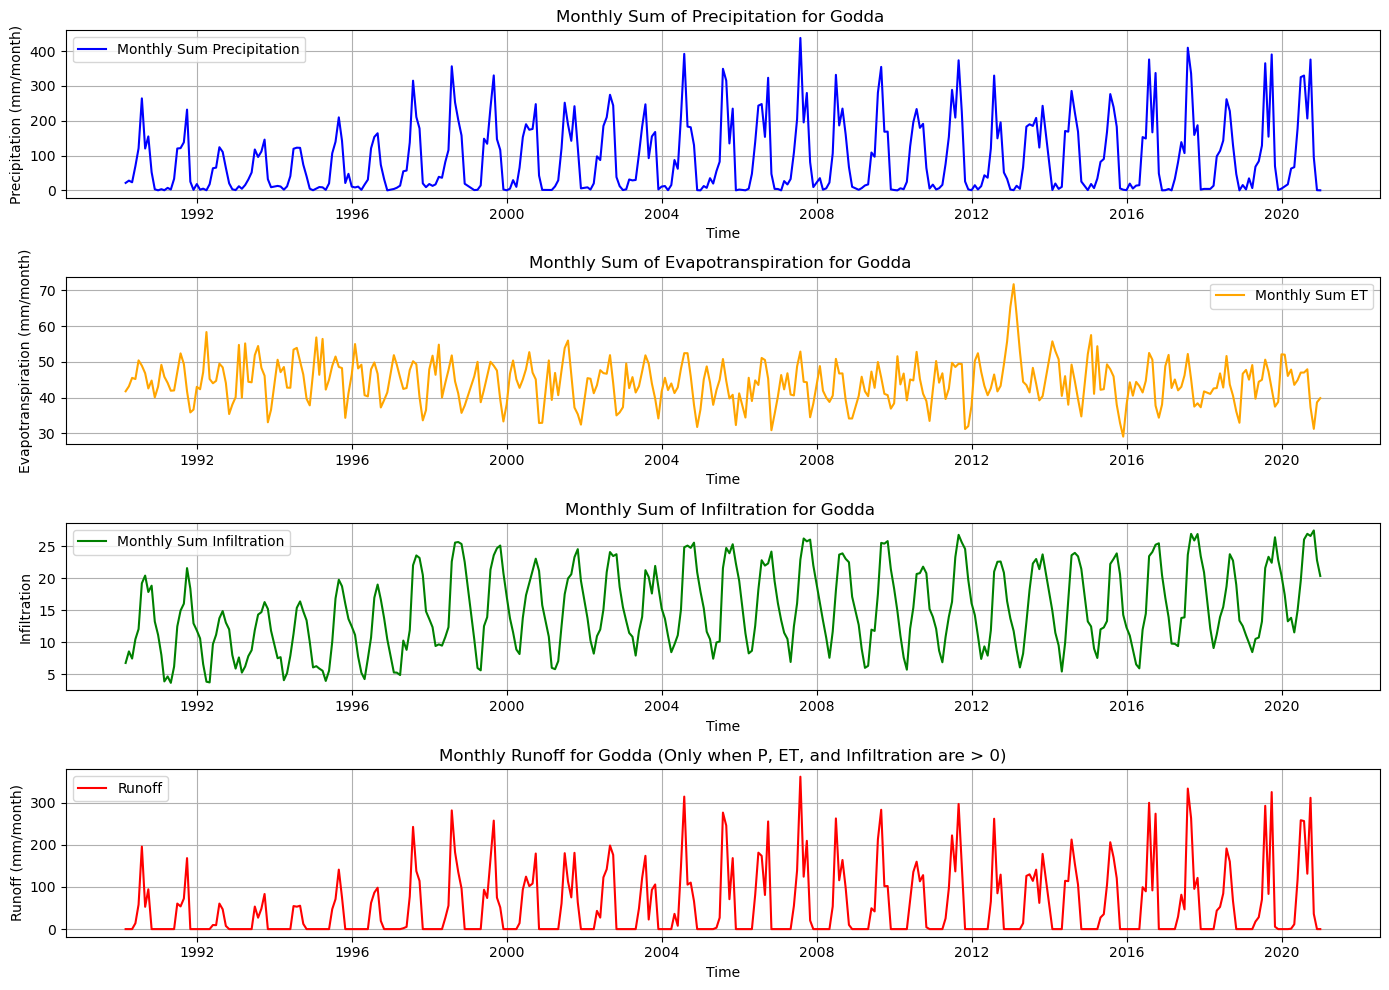

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define latitude and longitude bounds for Godda, Jharkhand
godda_lat_bounds = [24.5, 25.5]  # approximate latitude range for Godda
godda_lon_bounds = [87.0, 88.0]  # approximate longitude range for Godda

# Subset the dataset for Godda district
godda_precipitation = dataset['PRECTOTCORR'].sel(lat=slice(godda_lat_bounds[0], godda_lat_bounds[1]),
                                                  lon=slice(godda_lon_bounds[0], godda_lon_bounds[1]))
godda_et = et.sel(lat=slice(godda_lat_bounds[0], godda_lat_bounds[1]),
                  lon=slice(godda_lon_bounds[0], godda_lon_bounds[1]))
godda_infiltration = dataset['Total_Infiltration'].sel(lat=slice(godda_lat_bounds[0], godda_lat_bounds[1]),
                                                       lon=slice(godda_lon_bounds[0], godda_lon_bounds[1]))

# Define a function to calculate monthly sums
def calculate_monthly_sum(data_array):
    return data_array.resample(time='1M').sum()

# Average precipitation, ET, and infiltration across Godda district
average_precipitation_godda = godda_precipitation.mean(dim=['lat', 'lon'])
monthly_sum_precipitation_godda = calculate_monthly_sum(average_precipitation_godda)

average_et_godda = godda_et.mean(dim=['lat', 'lon'])
monthly_sum_et_godda = calculate_monthly_sum(average_et_godda)

average_infiltration_godda = godda_infiltration.mean(dim=['lat', 'lon'])
monthly_sum_infiltration_godda = calculate_monthly_sum(average_infiltration_godda)

# Filter only months where precipitation, ET, and infiltration are all non-zero
valid_precipitation_godda = monthly_sum_precipitation_godda.where(
    (monthly_sum_precipitation_godda > 0) &
    (monthly_sum_et_godda > 0) &
    (monthly_sum_infiltration_godda > 0),
    drop=True
)

# Calculate Water Balance only for valid months
water_balance_godda = valid_precipitation_godda - (monthly_sum_et_godda.sel(time=valid_precipitation_godda.time) +
                                                   monthly_sum_infiltration_godda.sel(time=valid_precipitation_godda.time))

# Runoff calculation: if water_balance is positive, assume that extra water contributes to runoff
runoff_godda = water_balance_godda.where(water_balance_godda > 0, 0)

# Plotting each variable for Godda district
plt.figure(figsize=(14, 10))

# Plot Precipitation
plt.subplot(4, 1, 1)
plt.plot(valid_precipitation_godda.time, valid_precipitation_godda, label='Monthly Sum Precipitation', color='blue')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm/month)')
plt.title('Monthly Sum of Precipitation for Godda ')
plt.legend()
plt.grid()

# Plot Evapotranspiration
plt.subplot(4, 1, 2)
plt.plot(monthly_sum_et_godda.sel(time=valid_precipitation_godda.time).time, monthly_sum_et_godda.sel(time=valid_precipitation_godda.time), label='Monthly Sum ET', color='orange')
plt.xlabel('Time')
plt.ylabel('Evapotranspiration (mm/month)')
plt.title('Monthly Sum of Evapotranspiration for Godda ')
plt.legend()
plt.grid()

# Plot Infiltration
plt.subplot(4, 1, 3)
plt.plot(monthly_sum_infiltration_godda.sel(time=valid_precipitation_godda.time).time, monthly_sum_infiltration_godda.sel(time=valid_precipitation_godda.time), label='Monthly Sum Infiltration', color='green')
plt.xlabel('Time')
plt.ylabel('Infiltration')
plt.title('Monthly Sum of Infiltration for Godda ')
plt.legend()
plt.grid()

# Plot Runoff
plt.subplot(4, 1, 4)
plt.plot(runoff_godda.time, runoff_godda, label='Runoff', color='red')
plt.xlabel('Time')
plt.ylabel('Runoff (mm/month)')
plt.title('Monthly Runoff for Godda (Only when P, ET, and Infiltration are > 0)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [9]:
godda_precipitation

<xarray.DataArray 'PRECTOTCORR' (time: 11323, lat: 2, lon: 2)>
array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2020-12-31
  * lat      (lat) float32 24.75 25.25
  * lon      (lon) float32 87.25 87.75
Attributes:
    long_name:      Precipitation_Corrected
    standard_name:  Precipitation Corrected
    units:          mm/day

C:\Users\DELL\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\DELL\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
C:\Users\DELL\anaconda3\lib\site-packages\xarray\core\missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
C:\Users\DELL\anaconda3\lib\site-packages\xarray\core\missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use 

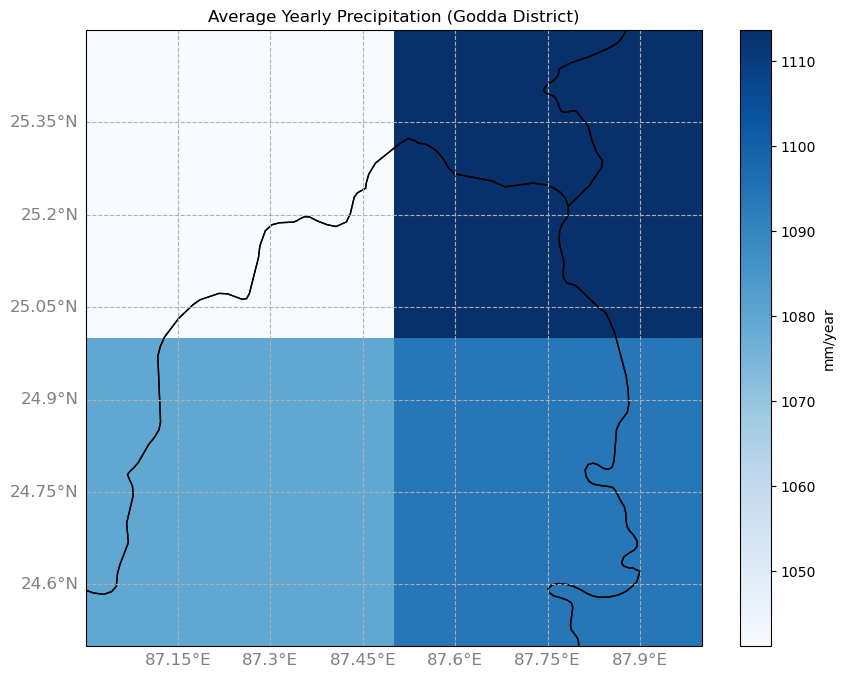

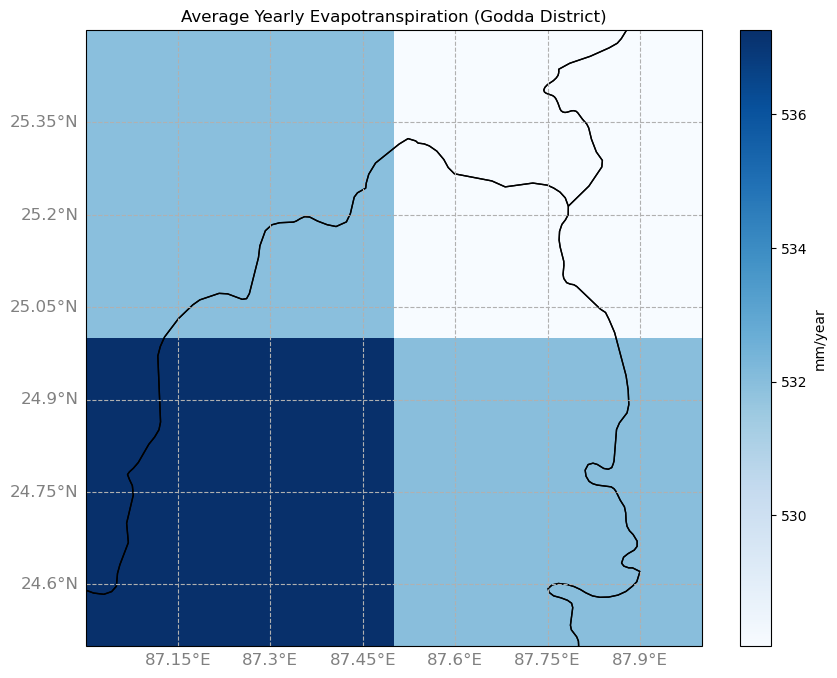

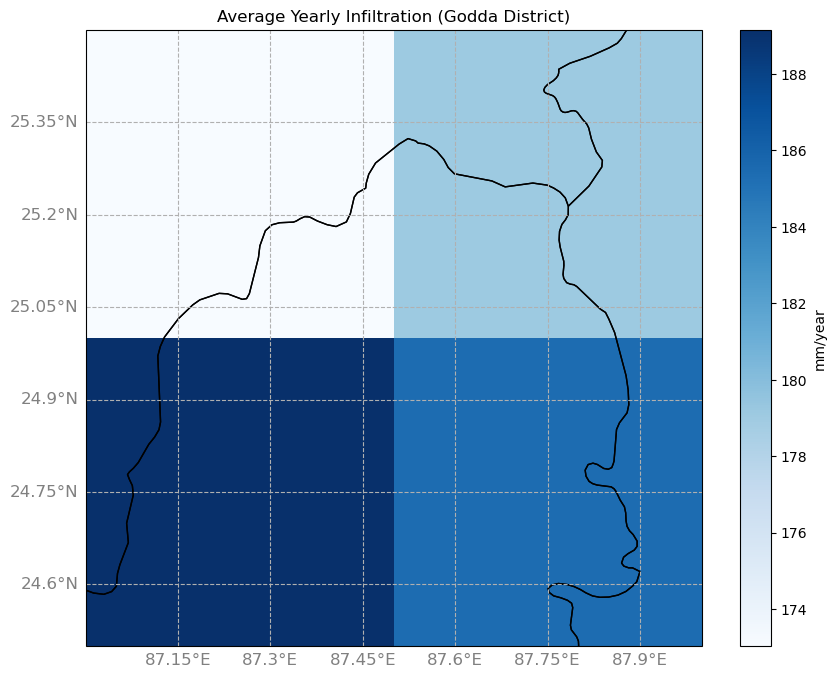

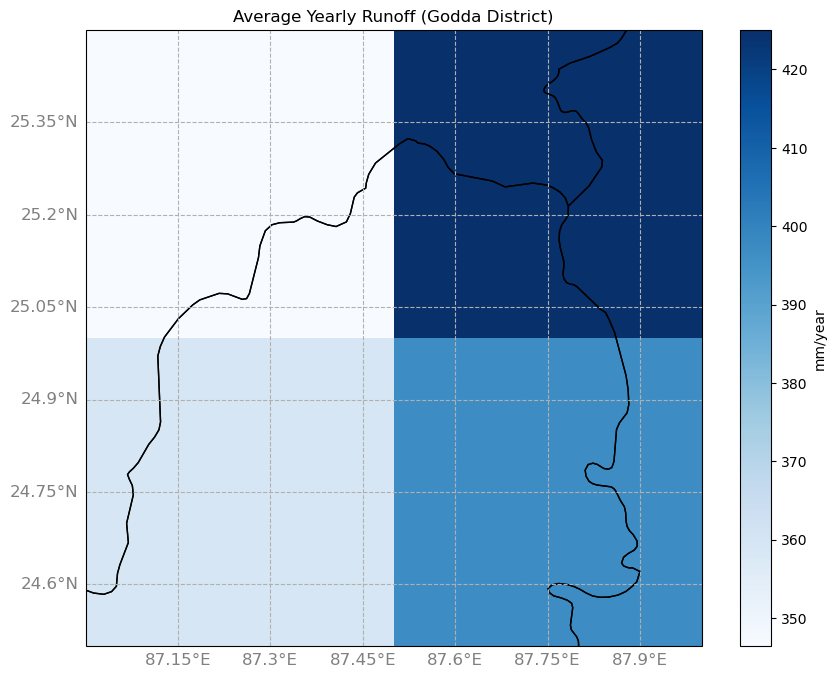

    Year  Precipitation (mm/year)  Evapotranspiration (mm/year)  \
0   1990               857.307495                    540.818588   
1   1991               701.914978                    529.280853   
2   1992               476.445007                    537.412460   
3   1993               625.847656                    554.116135   
4   1994               561.490112                    560.292847   
5   1995               722.200134                    566.192413   
6   1996               611.837585                    543.956818   
7   1997              1024.570068                    537.307419   
8   1998              1290.500000                    537.128662   
9   1999              1131.962402                    530.056320   
10  2000              1093.517578                    529.544220   
11  2001              1117.325195                    524.504486   
12  2002              1179.569824                    520.884399   
13  2003              1055.145142                    530.76698

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np

# Load the dataset
# dataset_path = r'C:\Users\DELL\OneDrive - iitr.ac.in\sandeep\data\updated_dataset.nc'
# dataset = xr.open_dataset(dataset_path)

# Extract relevant variables
precipitation = dataset['PRECTOTCORR']  # Precipitation
et = dataset['ET']                      # Evapotranspiration (replace if your dataset has a different name)
infiltration = dataset['Total_Infiltration']  # Infiltration

# Define latitude and longitude bounds for Godda, Jharkhand
godda_lat_bounds = [24.5, 25.5]  # approximate latitude range for Godda
godda_lon_bounds = [87.0, 88.0]  # approximate longitude range for Godda

# Subset the dataset for Godda district
godda_precipitation = precipitation.sel(lat=slice(godda_lat_bounds[0], godda_lat_bounds[1]),
                                        lon=slice(godda_lon_bounds[0], godda_lon_bounds[1]))
godda_et = et.sel(lat=slice(godda_lat_bounds[0], godda_lat_bounds[1]),
                  lon=slice(godda_lon_bounds[0], godda_lon_bounds[1]))
godda_infiltration = infiltration.sel(lat=slice(godda_lat_bounds[0], godda_lat_bounds[1]),
                                      lon=slice(godda_lon_bounds[0], godda_lon_bounds[1]))

# Calculate yearly sums for each variable
godda_precipitation_yearly = godda_precipitation.resample(time='1Y').sum(dim='time')
godda_et_yearly = godda_et.resample(time='1Y').sum(dim='time')
godda_infiltration_yearly = godda_infiltration.resample(time='1Y').sum(dim='time')

# Ensure all variables have the same dimensions and coordinates
godda_et_yearly = godda_et_yearly.interp_like(godda_precipitation_yearly)
godda_infiltration_yearly = godda_infiltration_yearly.interp_like(godda_precipitation_yearly)

# Calculate runoff as the residual of the water balance
godda_runoff_yearly = godda_precipitation_yearly - (godda_et_yearly + godda_infiltration_yearly)
godda_runoff_yearly = godda_runoff_yearly.where(godda_runoff_yearly > 0, 0)

# Calculate the average over all years for each variable
avg_precipitation = godda_precipitation_yearly.mean(dim='time')
avg_et = godda_et_yearly.mean(dim='time')
avg_infiltration = godda_infiltration_yearly.mean(dim='time')
avg_runoff = godda_runoff_yearly.mean(dim='time')

# Plot the maps for each average variable with state boundaries and lat/lon gridlines
def plot_map(data, title):
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and boundaries
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    ax.add_feature(cfeature.STATES, edgecolor='black')  # Add state boundaries
    
    # Plot the data
    im = ax.pcolormesh(data.lon, data.lat, data, transform=ccrs.PlateCarree(), cmap='Blues')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, orientation='vertical', label='mm/year')
    
    # Set title
    ax.set_title(title)

    # Add gridlines with labels
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    
    plt.show()

# Plot each map
plot_map(avg_precipitation, 'Average Yearly Precipitation (Godda District)')
plot_map(avg_et, 'Average Yearly Evapotranspiration (Godda District)')
plot_map(avg_infiltration, 'Average Yearly Infiltration (Godda District)')
plot_map(avg_runoff, 'Average Yearly Runoff (Godda District)')

# Create a table summarizing the yearly values
yearly_data = {
    'Year': godda_precipitation_yearly['time.year'].values,
    'Precipitation (mm/year)': godda_precipitation_yearly.mean(dim=['lat', 'lon']).values,
    'Evapotranspiration (mm/year)': godda_et_yearly.mean(dim=['lat', 'lon']).values,
    'Infiltration (mm/year)': godda_infiltration_yearly.mean(dim=['lat', 'lon']).values,
    'Runoff (mm/year)': godda_runoff_yearly.mean(dim=['lat', 'lon']).values
}

# Convert to DataFrame for better visualization
yearly_df = pd.DataFrame(yearly_data)
print(yearly_df)

# Display the average values for all years
average_values = {
    'Precipitation (Avg mm/year)': avg_precipitation.mean().values,
    'Evapotranspiration (Avg mm/year)': avg_et.mean().values,
    'Infiltration (Avg mm/year)': avg_infiltration.mean().values,
    'Runoff (Avg mm/year)': avg_runoff.mean().values
}

# Create a DataFrame for the average values
avg_df = pd.DataFrame([average_values])
print(avg_df)
